### E10S Experiment Aurora

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.plotly as py
import IPython

from __future__ import division
from moztelemetry.spark import get_pings, get_one_ping_per_client, get_pings_properties
from montecarlino import grouped_permutation_test

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

160

In [3]:
def chi2_distance(xs, ys, eps = 1e-10, normalize = True):
    histA = xs.sum(axis=0)
    histB = ys.sum(axis=0)
    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d

def median_diff(xs, ys):
    return np.median(xs) - np.median(ys)

def compare_histogram(histogram, e10s, none10s):
    pvalue = grouped_permutation_test(chi2_distance, [e10s, none10s], num_samples=100)
    
    eTotal = e10s.sum()
    nTotal = none10s.sum()
        
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(len(e10s)), "non e10s ({} samples)".format(len(none10s))])

    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
        
    print "The probability that the distributions for {} are differing by chance is {:.2f}.".format(histogram, pvalue)
    
def normalize_uptime_hour(frame):
    frame = frame[frame["payload/simpleMeasurements/uptime"] > 0]
    frame = 60 * frame.apply(lambda x: x/frame["payload/simpleMeasurements/uptime"]) # Metric per hour
    frame.drop('payload/simpleMeasurements/uptime', axis=1, inplace=True)
    return frame
    
def compare_count_histograms(pings, *histograms_names):
    properties = histograms_names + ("payload/simpleMeasurements/uptime", "e10s")

    frame = pd.DataFrame(get_pings_properties(pings, properties).collect())

    e10s = frame[frame["e10s"] == True]
    e10s = normalize_uptime_hour(e10s)
    
    none10s = frame[frame["e10s"] == False]
    none10s = normalize_uptime_hour(none10s)
    
    for histogram in e10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        compare_scalars(histogram + " per hour", e10s[histogram].dropna(), none10s[histogram].dropna())

        
def compare_histograms(pings, *histogram_names):
    frame = pd.DataFrame(get_pings_properties(pings, histogram_names + ("e10s",), with_processes=True).collect())
    e10s = frame[frame["e10s"] == True]
    none10s = frame[frame["e10s"] == False]
    
    for histogram in none10s.columns:
        if histogram == "e10s" or histogram.endswith("_parent") or histogram.endswith("_children"):
            continue
            
        has_children = np.sum(e10s[histogram + "_children"].notnull()) > 0
        has_parent = np.sum(e10s[histogram + "_parent"].notnull()) > 0
        
        if has_children and has_parent:
            compare_histogram(histogram + " (parent + children)", e10s[histogram].dropna(), none10s[histogram].dropna())
            
        if has_parent:
            compare_histogram(histogram + " (parent)", e10s[histogram + "_parent"].dropna(), none10s[histogram].dropna())
            
        if has_children:
            compare_histogram(histogram + " (children)", e10s[histogram + "_children"].dropna(), none10s[histogram].dropna())
                    

                
def compare_scalars(metric, *groups):
    print "Median difference in {} is {:.2f}, ({:.2f}, {:.2f}).".format(metric,
                                                                        median_diff(*groups), 
                                                                        np.median(groups[0]),
                                                                        np.median(groups[1]))
    print "The probablity of this effect being purely by chance is {:.2f}.". \
        format(grouped_permutation_test(median_diff, groups, num_samples=10000))

#### Get e10s and non-e10s partitions

In [4]:
def is_in_e10s_experiment(ping):
    try:
        experiment = ping["environment"]["addons"]["activeExperiment"]
        return experiment["id"] == "e10s-enabled-aurora-20151020@experiments.mozilla.org" and \
               (experiment["branch"] == "control" or experiment["branch"] == "experiment")   
    except:
        return False

In [5]:
pings = get_pings(sc, app="Firefox", channel="aurora", version="43.0a2", submission_date=("20151023", "20151027"))\
        .filter(is_in_e10s_experiment)

How many pings do we have in each branch?

In [37]:
pings.map(lambda x: (x["environment"]["addons"]["activeExperiment"]["branch"], 1))\
     .reduceByKey(lambda x, y: x + y)\
     .collect()

[(u'experiment', 263044), (u'control', 258968)]

In [6]:
def sample_by_client_id(ping):
    sample_id = ping.get("meta/sampleId", 100)
    return sample_id < 33

# Used only for testing
# pings = pings.filter(sample_by_client_id)

Get a single ping for each client, but make sure it's not the first one as the experiment branch will not be enforced until the next restart

In [7]:
def get_one_ping_per_client(pings, reduceFunc):
    return pings.map(lambda p: (p["clientId"], p)).\
                     reduceByKey(reduceFunc).\
                     map(lambda p: p[1])
        
def not_first(x, y):
    return x if x["meta"]["documentId"] not in first_ping_of_clients[x["clientId"]] else y

In [8]:
first_ping_of_clients = \
      pings.map(lambda p: (p["clientId"], p))\
     .reduceByKey(lambda x, y: x if x["meta"]["creationTimestamp"] < y["meta"]["creationTimestamp"] else y)\
     .map(lambda p: (p[0], p[1]["meta"]["documentId"]))\
     .collectAsMap()

In [9]:
subset = get_one_ping_per_client(pings, not_first)

How many clients do we have in each branch?

In [10]:
subset.map(lambda x: (x["environment"]["addons"]["activeExperiment"]["branch"], 1))\
      .reduceByKey(lambda x, y: x + y)\
      .collect()

[(u'experiment', 35421), (u'control', 35491)]

How many clients have a mismatching experiment state?

In [11]:
def e10s_status_mismatch(ping):
    branch = ping["environment"]["addons"]["activeExperiment"]["branch"]
    branch_status = True if branch == "experiment" else False
    return (branch, branch_status != ping["environment"]["settings"]["e10sEnabled"])

In [12]:
subset.map(e10s_status_mismatch).reduceByKey(lambda x, y: x + y).collect()

[(u'experiment', 65), (u'control', 6607)]

Exclude mismatching clients

In [18]:
subset = subset.filter(lambda p: not e10s_status_mismatch(p)[1])

In [19]:
subset.map(e10s_status_mismatch).reduceByKey(lambda x, y: x + y).collect()

[(u'experiment', 0), (u'control', 0)]

In [20]:
def add_e10s_discriminator(ping):
    ping["e10s"] = ping["environment"]["settings"]["e10sEnabled"]
    return ping

subset = subset.map(add_e10s_discriminator)

In [21]:
def add_gecko_activity(ping):
    threads = ping["payload"].get("threadHangStats", {})
    uptime = ping["payload"]["simpleMeasurements"].get("uptime", -1)
    
    if not threads or uptime <= 0:
        return ping
    
    for thread in threads:
        if thread["name"] == "Gecko":
            activity = thread["activity"]["values"]
            histogram = pd.Series(activity.values(), index=map(int, activity.keys())).sort_index()
            over100 = histogram[histogram.index > 100].sum()
            ping["gecko_hangs_per_minute"] = over100/uptime
        
    return ping

subset = subset.map(add_gecko_activity)

## 1. Generic stuff

In [22]:
simple = pd.DataFrame(get_pings_properties(subset, [
    "payload/simpleMeasurements/firstPaint",
    "payload/simpleMeasurements/sessionRestored",
    "payload/simpleMeasurements/sessionRestoreInit",
    "payload/simpleMeasurements/shutdownDuration",
    "e10s",
    "gecko_hangs_per_minute"
]).collect())

eSimple = simple[simple["e10s"] == True]
nSimple = simple[simple["e10s"] == False]
len(eSimple), len(nSimple)

(35356, 28884)

In [23]:
len(eSimple), len(nSimple)

(35356, 28884)

#### a) Startup time evaluation:

In [24]:
compare_scalars("startup time", eSimple["payload/simpleMeasurements/firstPaint"].dropna(), nSimple["payload/simpleMeasurements/firstPaint"].dropna())

Median difference in startup time is 148.00, (4672.00, 4524.00).
The probablity of this effect being purely by chance is 0.00.


#### b) Shutdown time evaluation:

In [25]:
compare_scalars("shutdown duration", eSimple["payload/simpleMeasurements/shutdownDuration"], nSimple["payload/simpleMeasurements/shutdownDuration"])

Median difference in shutdown duration is 12.00, (1229.00, 1217.00).
The probablity of this effect being purely by chance is 0.32.


#### c) Animation smoothness:

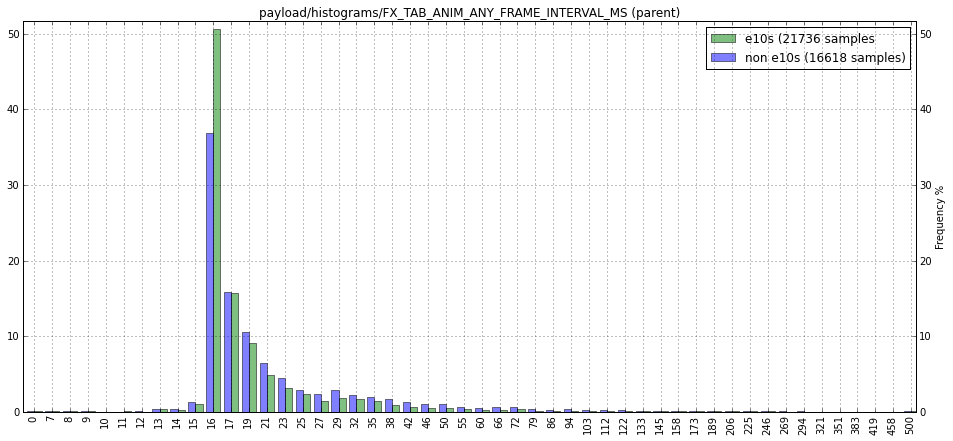

The probability that the distributions for payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


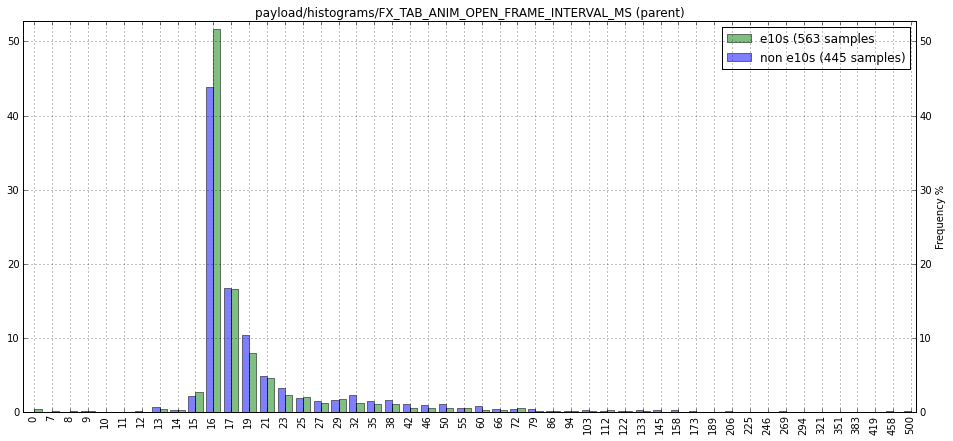

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS (parent) are differing by chance is 0.04.


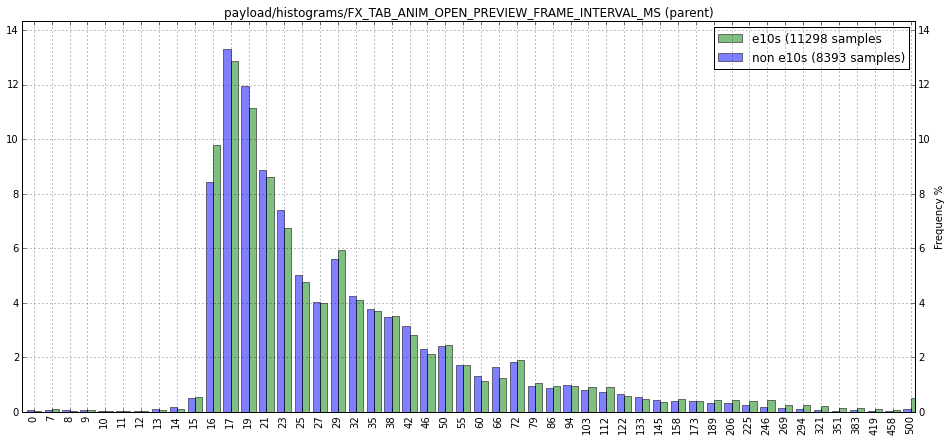

The probability that the distributions for payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS (parent) are differing by chance is 0.00.


In [26]:
compare_histograms(subset,
                   "payload/histograms/FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_FRAME_INTERVAL_MS",
                   "payload/histograms/FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS")

#### d) Graphics:

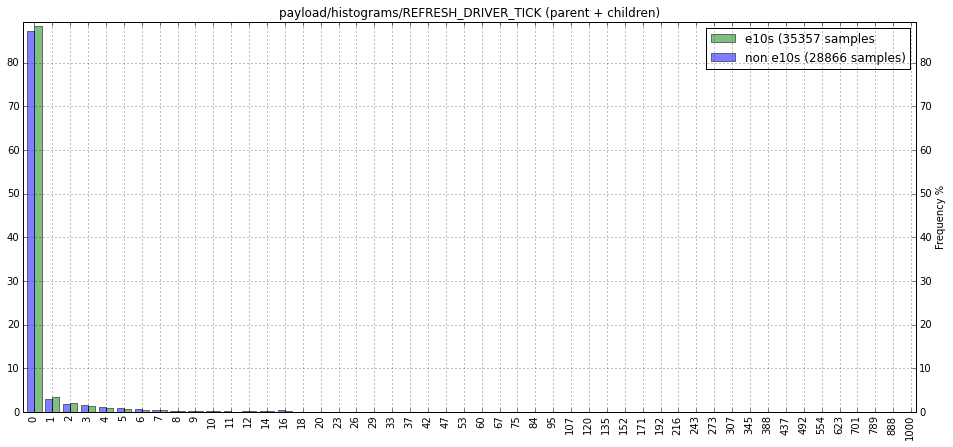

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent + children) are differing by chance is 0.28.


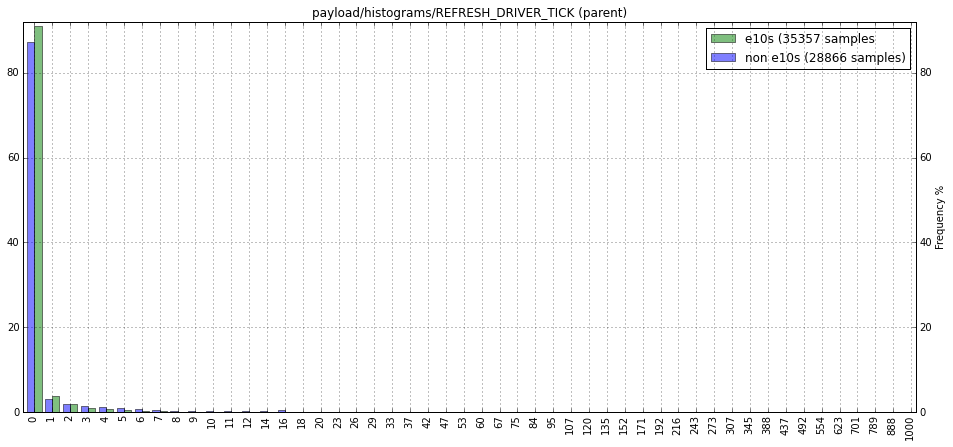

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (parent) are differing by chance is 0.03.


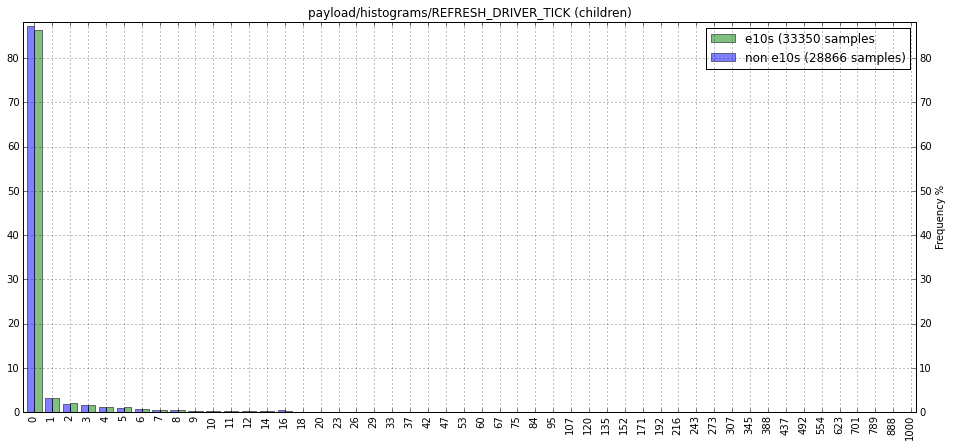

The probability that the distributions for payload/histograms/REFRESH_DRIVER_TICK (children) are differing by chance is 0.67.


In [27]:
compare_histograms(subset, "payload/histograms/REFRESH_DRIVER_TICK")

## 2. Responsivness

#### a) Event processing

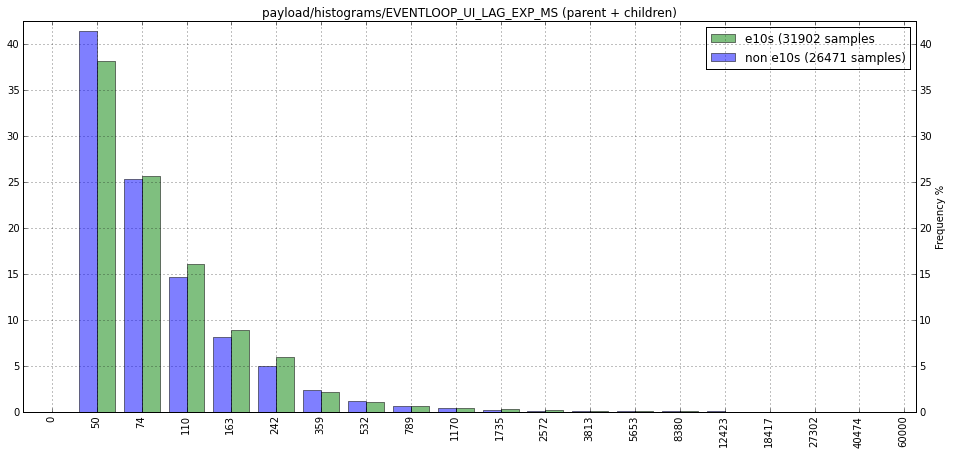

The probability that the distributions for payload/histograms/EVENTLOOP_UI_LAG_EXP_MS (parent + children) are differing by chance is 0.00.


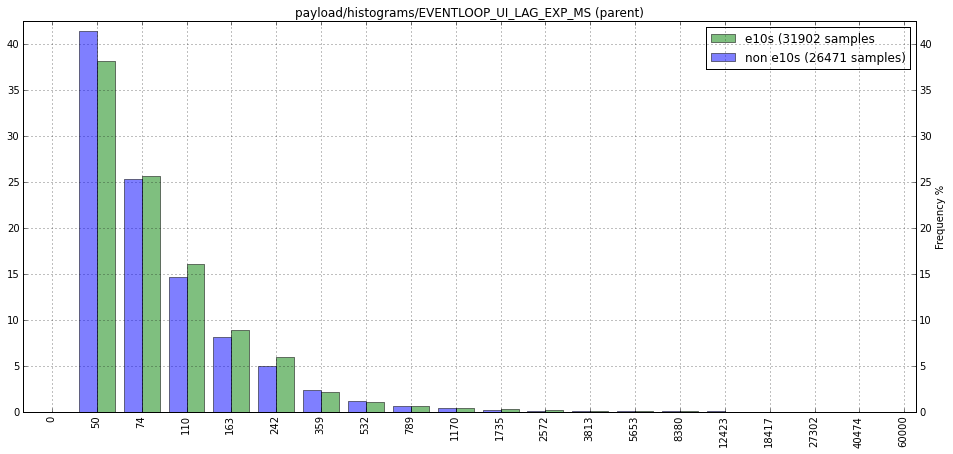

The probability that the distributions for payload/histograms/EVENTLOOP_UI_LAG_EXP_MS (parent) are differing by chance is 0.00.


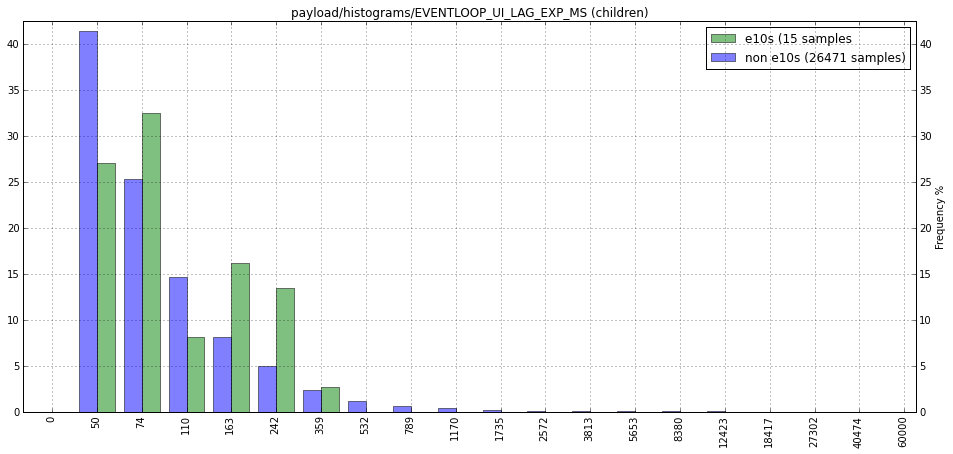

The probability that the distributions for payload/histograms/EVENTLOOP_UI_LAG_EXP_MS (children) are differing by chance is 0.04.


In [28]:
compare_histograms(subset, "payload/histograms/EVENTLOOP_UI_LAG_EXP_MS")

In [29]:
compare_scalars("hangs over 100ms per minute", eSimple["gecko_hangs_per_minute"], nSimple["gecko_hangs_per_minute"])

Median difference in hangs over 100ms per minute is 2.80, (25.00, 22.20).
The probablity of this effect being purely by chance is 0.00.


#### b) Plugins

In [30]:
compare_count_histograms(subset, "payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin")

Median difference in payload/keyedHistograms/SUBPROCESS_ABNORMAL_ABORT/plugin per hour is -0.13, (0.40, 0.53).
The probablity of this effect being purely by chance is 0.13.


#### c) Page load

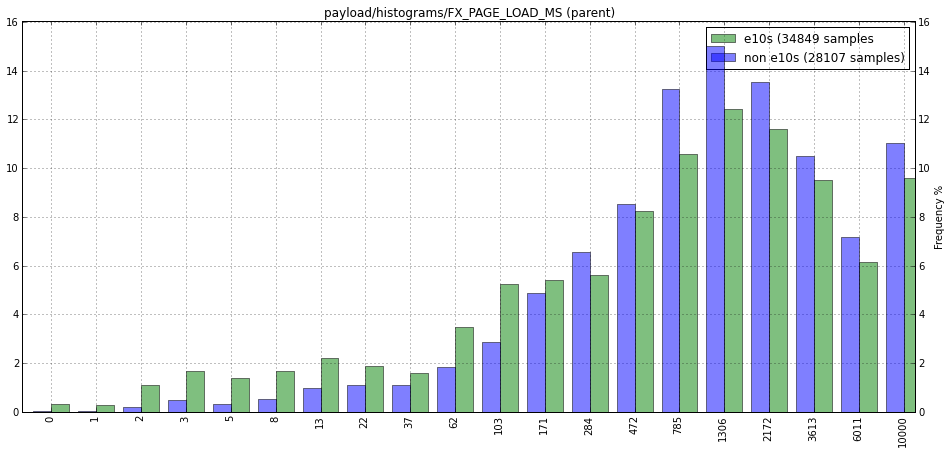

The probability that the distributions for payload/histograms/FX_PAGE_LOAD_MS (parent) are differing by chance is 0.00.


In [31]:
compare_histograms(subset, "payload/histograms/FX_PAGE_LOAD_MS")

#### d) Slow scripts

In [32]:
compare_count_histograms(subset, "payload/histograms/SLOW_SCRIPT_NOTICE_COUNT")

Median difference in payload/histograms/SLOW_SCRIPT_NOTICE_COUNT per hour is -0.12, (0.32, 0.44).
The probablity of this effect being purely by chance is 0.01.


#### e) Window open time

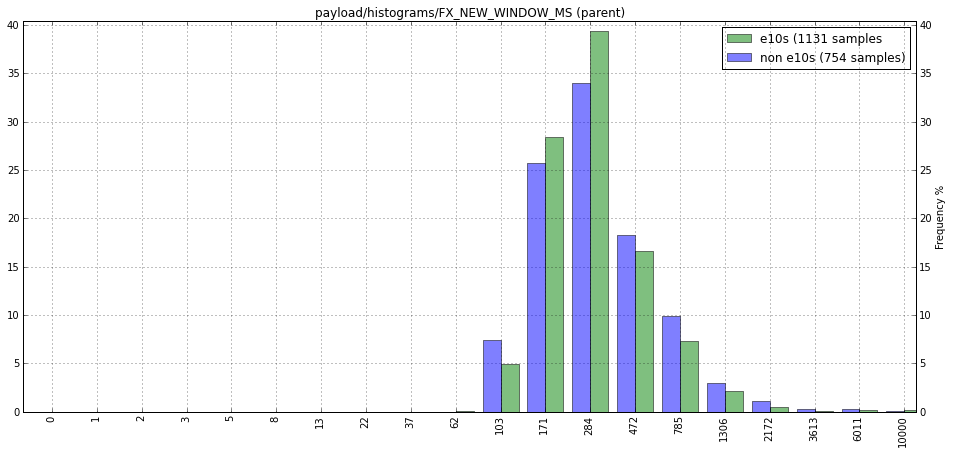

The probability that the distributions for payload/histograms/FX_NEW_WINDOW_MS (parent) are differing by chance is 0.22.


In [33]:
compare_histograms(subset, "payload/histograms/FX_NEW_WINDOW_MS")

#### f) Garbage collection

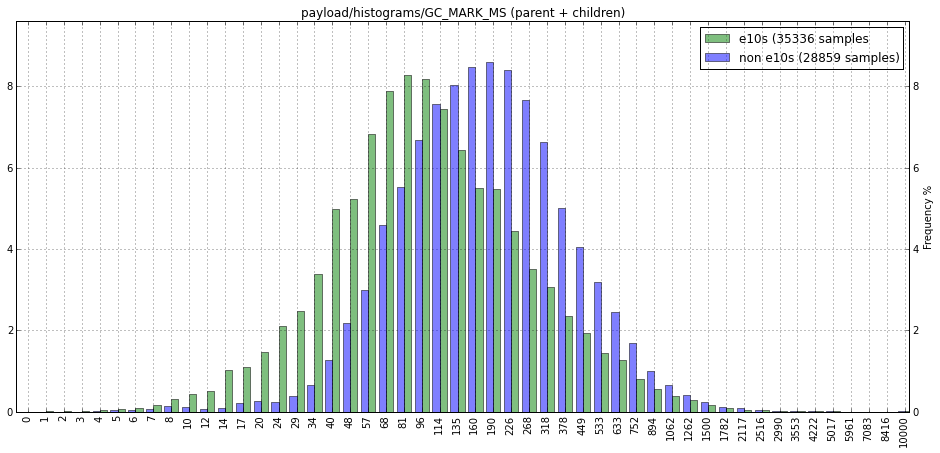

The probability that the distributions for payload/histograms/GC_MARK_MS (parent + children) are differing by chance is 0.00.


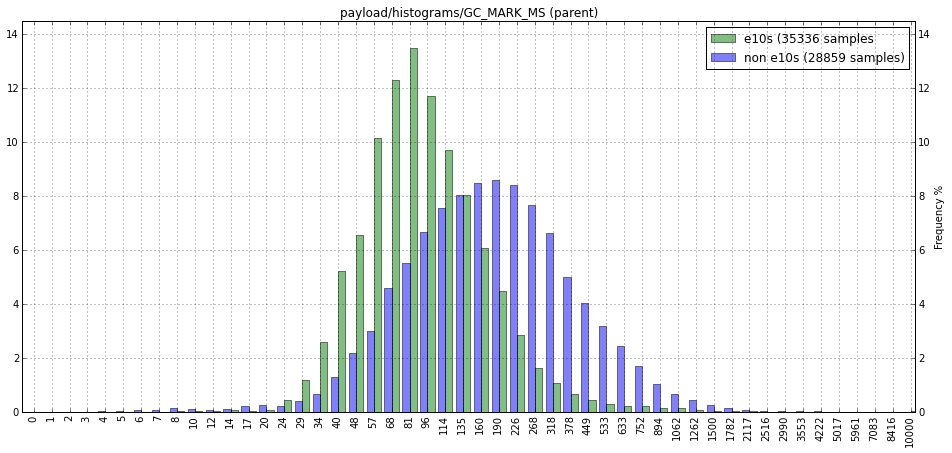

The probability that the distributions for payload/histograms/GC_MARK_MS (parent) are differing by chance is 0.00.


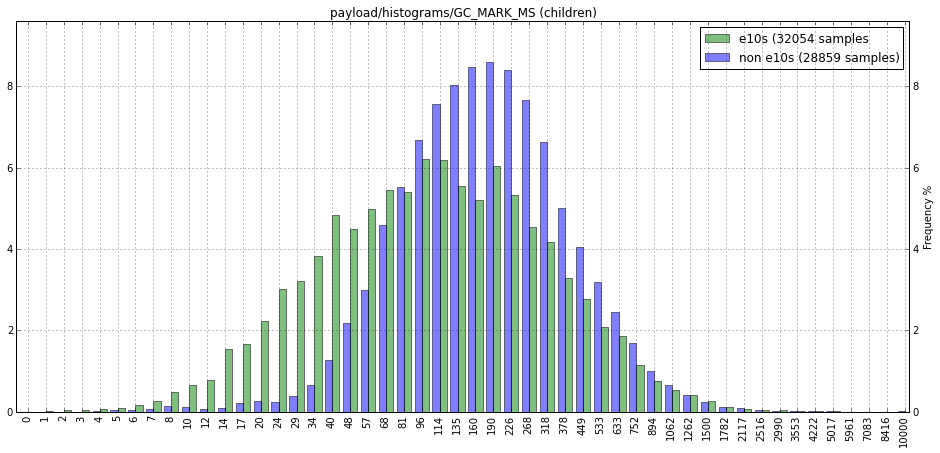

The probability that the distributions for payload/histograms/GC_MARK_MS (children) are differing by chance is 0.00.


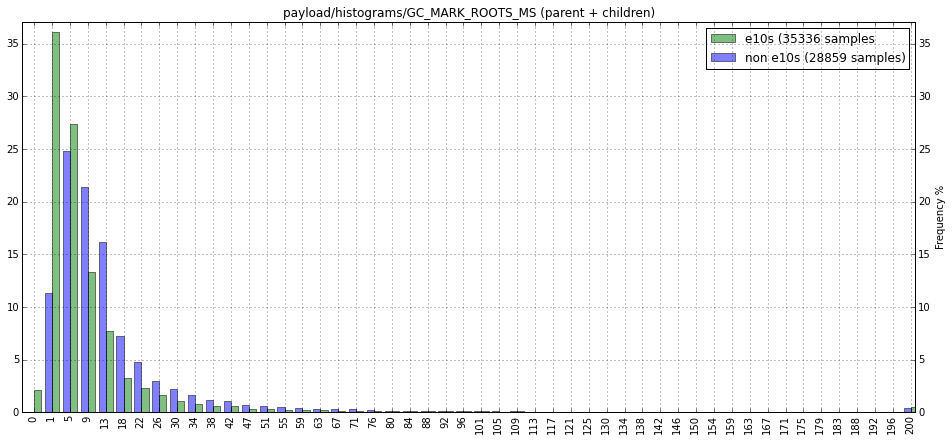

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent + children) are differing by chance is 0.00.


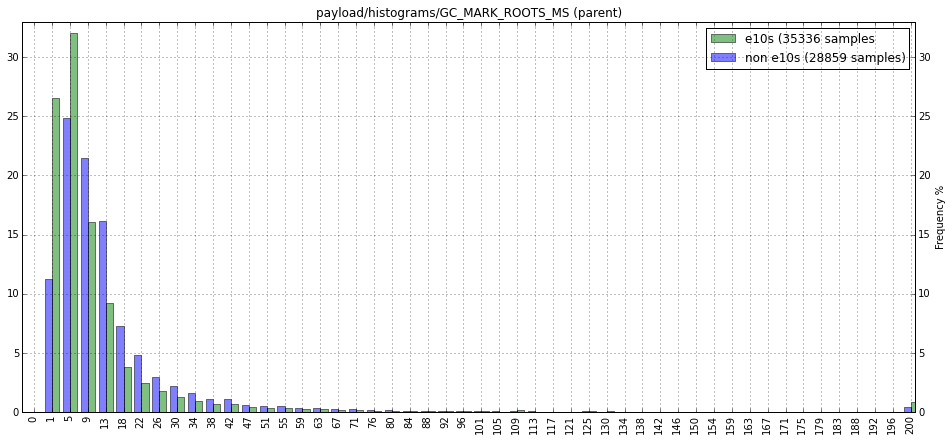

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (parent) are differing by chance is 0.00.


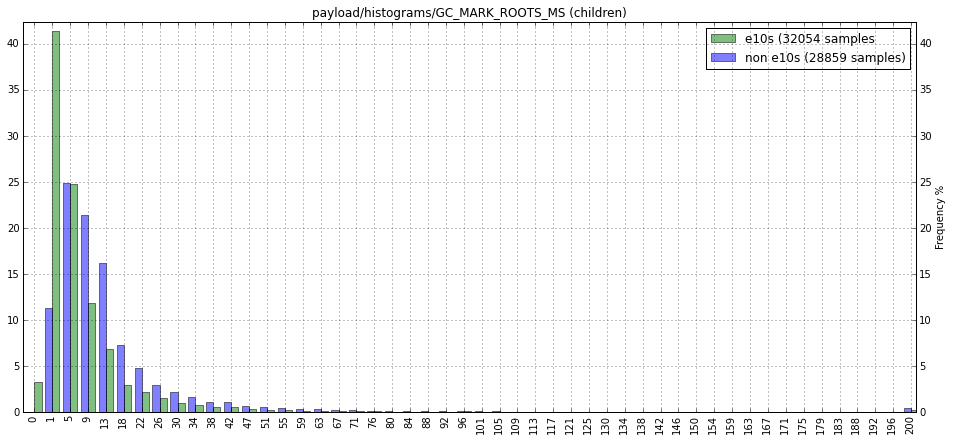

The probability that the distributions for payload/histograms/GC_MARK_ROOTS_MS (children) are differing by chance is 0.00.


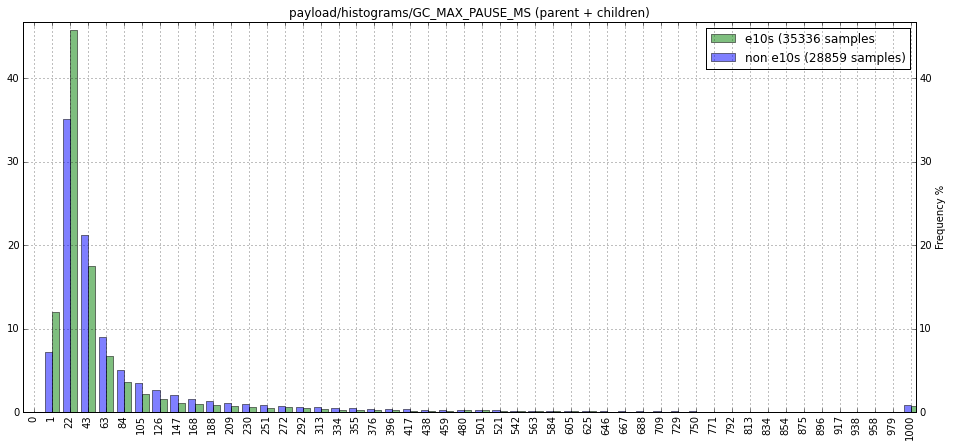

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


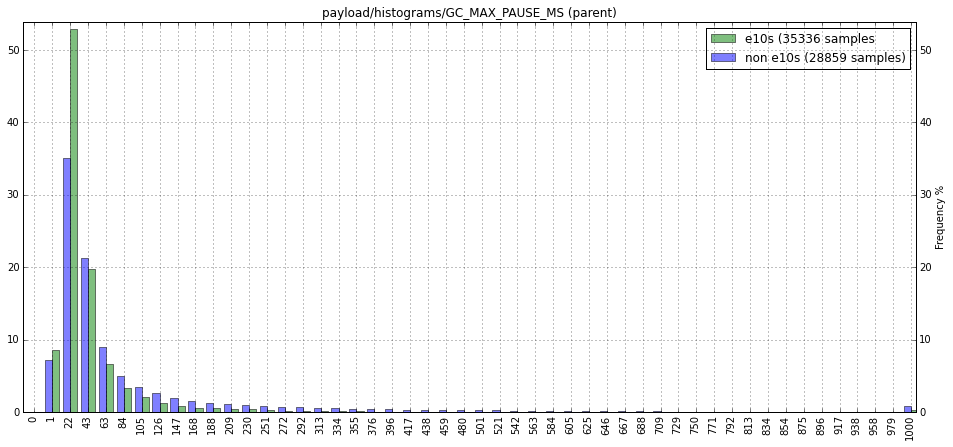

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


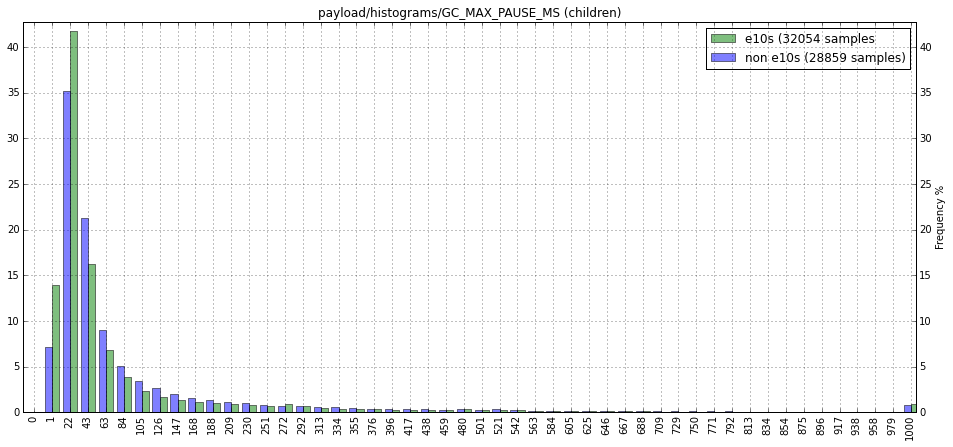

The probability that the distributions for payload/histograms/GC_MAX_PAUSE_MS (children) are differing by chance is 0.00.


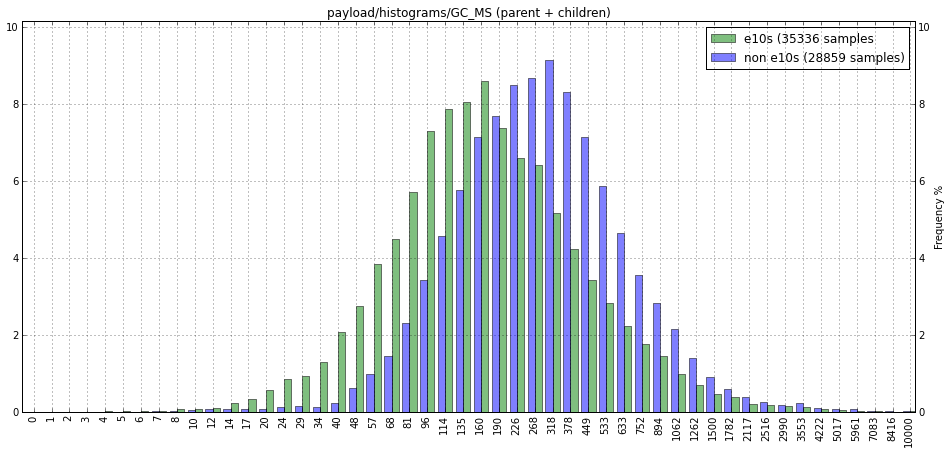

The probability that the distributions for payload/histograms/GC_MS (parent + children) are differing by chance is 0.00.


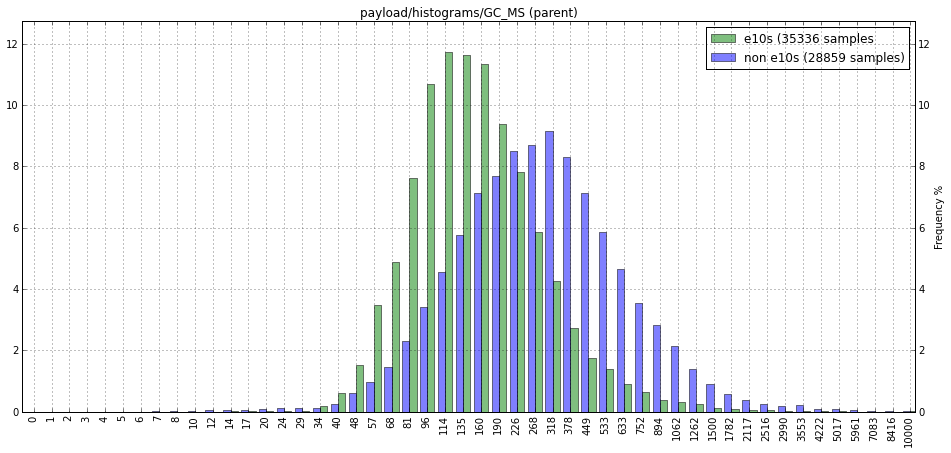

The probability that the distributions for payload/histograms/GC_MS (parent) are differing by chance is 0.00.


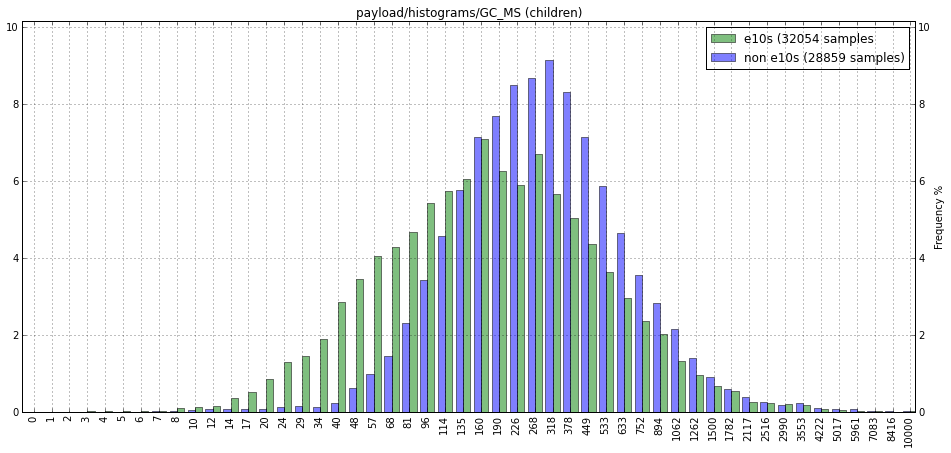

The probability that the distributions for payload/histograms/GC_MS (children) are differing by chance is 0.00.


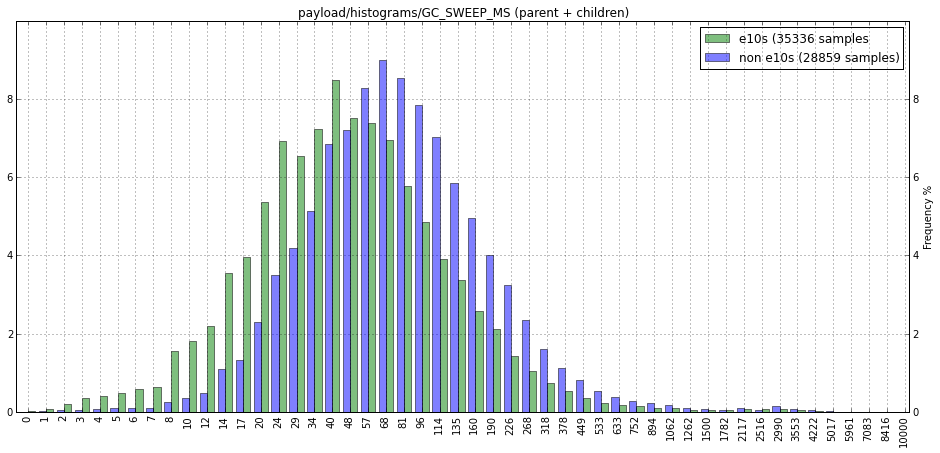

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent + children) are differing by chance is 0.00.


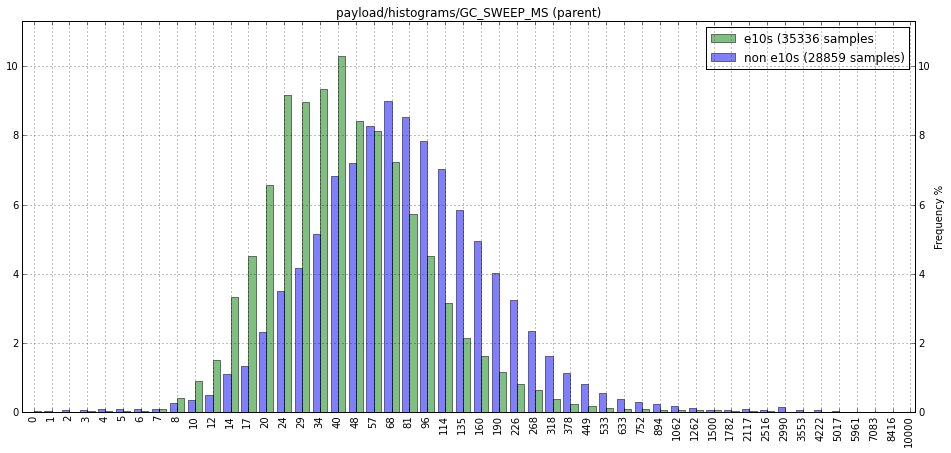

The probability that the distributions for payload/histograms/GC_SWEEP_MS (parent) are differing by chance is 0.00.


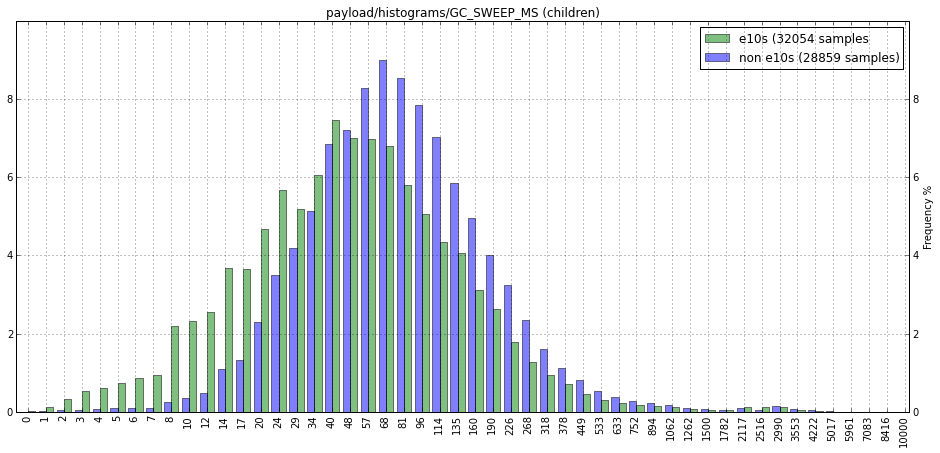

The probability that the distributions for payload/histograms/GC_SWEEP_MS (children) are differing by chance is 0.00.


In [34]:
compare_histograms(subset, 
                   "payload/histograms/GC_MS", 
                   "payload/histograms/GC_MAX_PAUSE_MS", 
                   "payload/histograms/GC_MARK_MS", 
                   "payload/histograms/GC_SWEEP_MS", 
                   "payload/histograms/GC_MARK_ROOTS_MS")

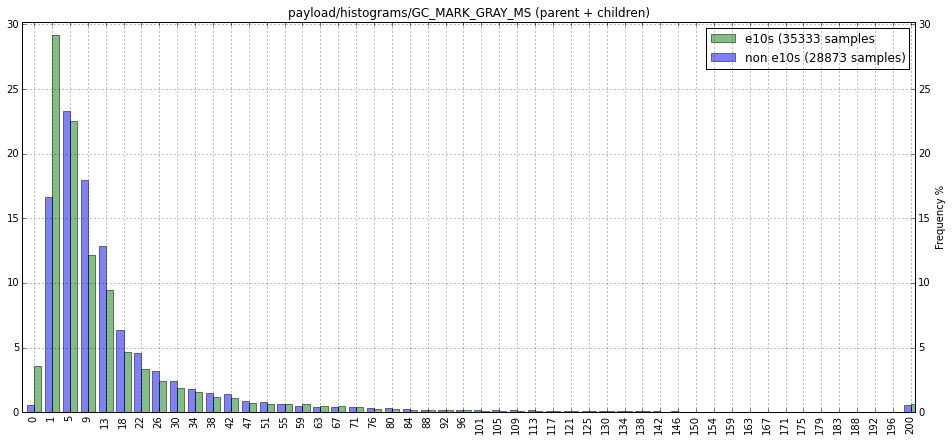

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent + children) are differing by chance is 0.00.


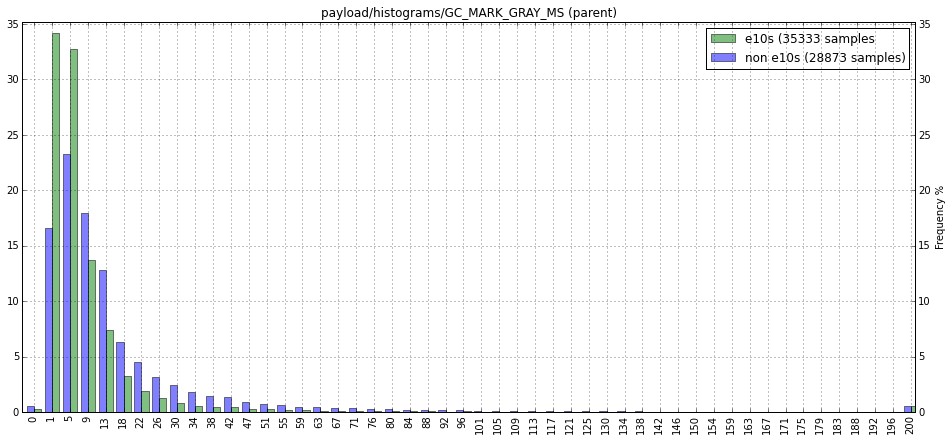

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (parent) are differing by chance is 0.00.


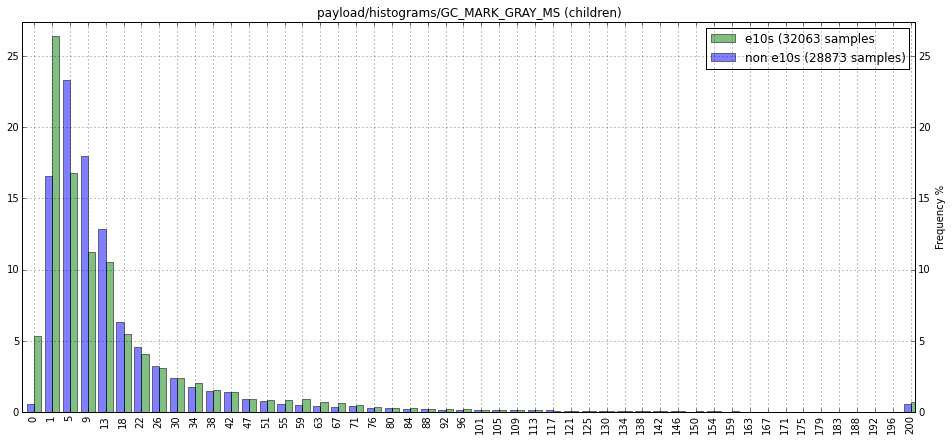

The probability that the distributions for payload/histograms/GC_MARK_GRAY_MS (children) are differing by chance is 0.00.


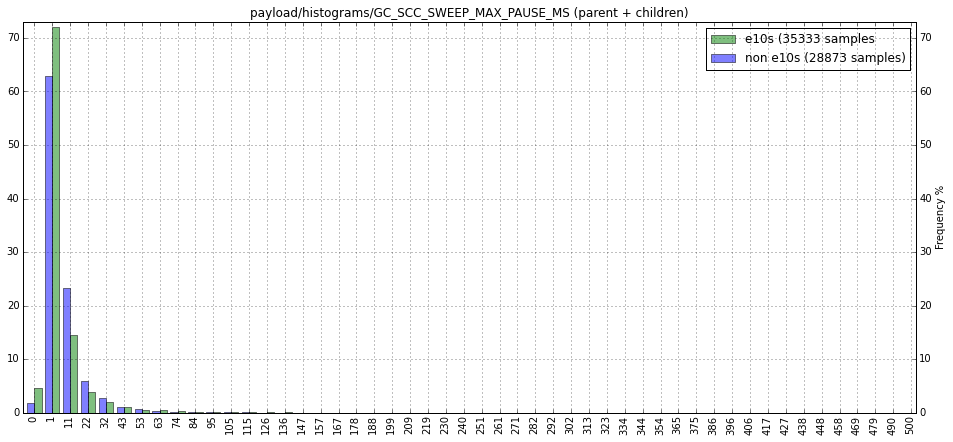

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent + children) are differing by chance is 0.00.


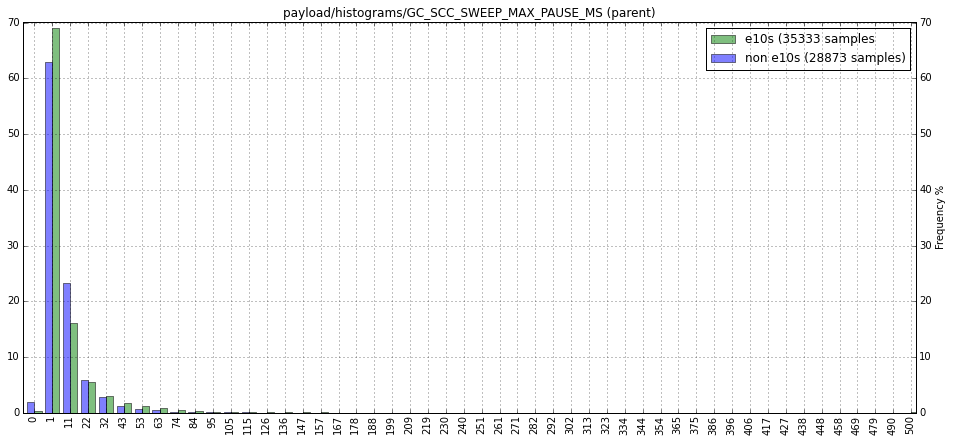

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (parent) are differing by chance is 0.00.


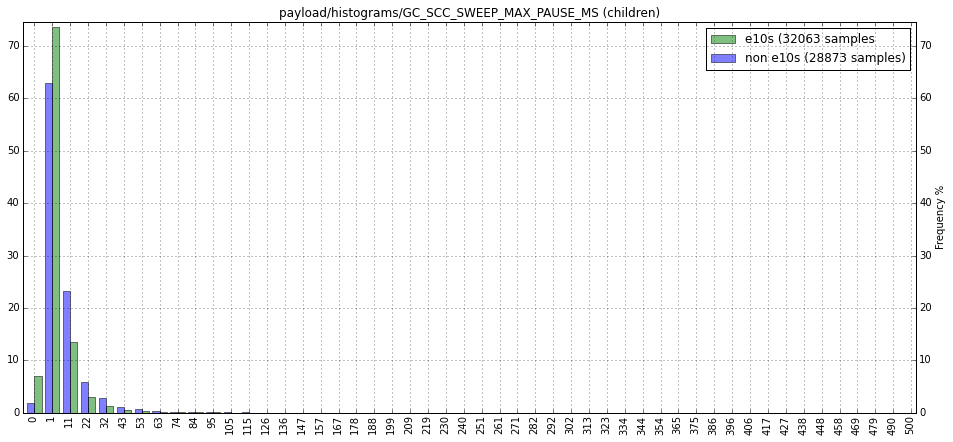

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS (children) are differing by chance is 0.00.


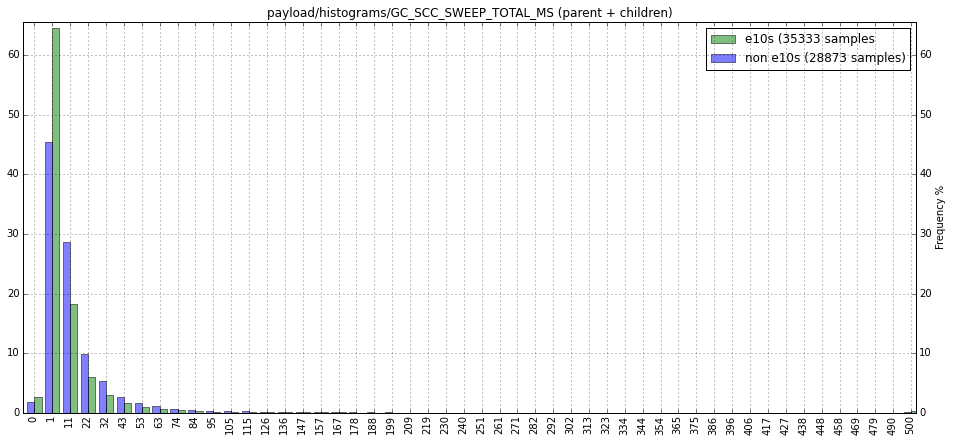

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent + children) are differing by chance is 0.00.


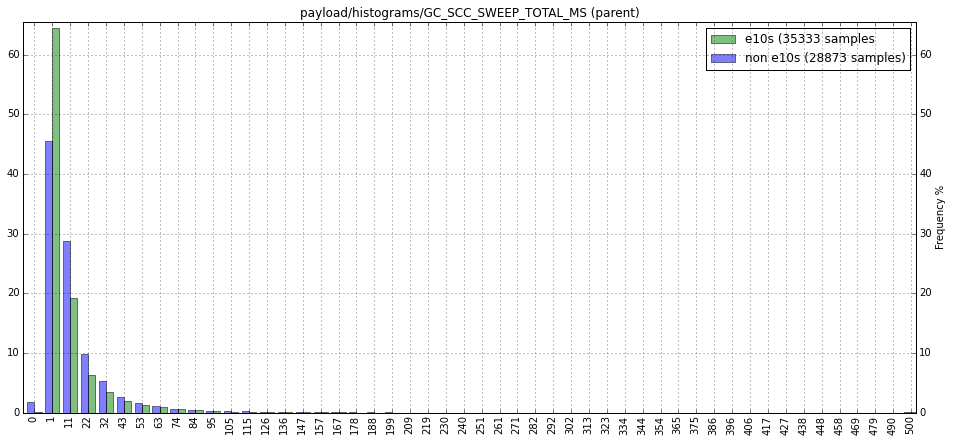

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (parent) are differing by chance is 0.00.


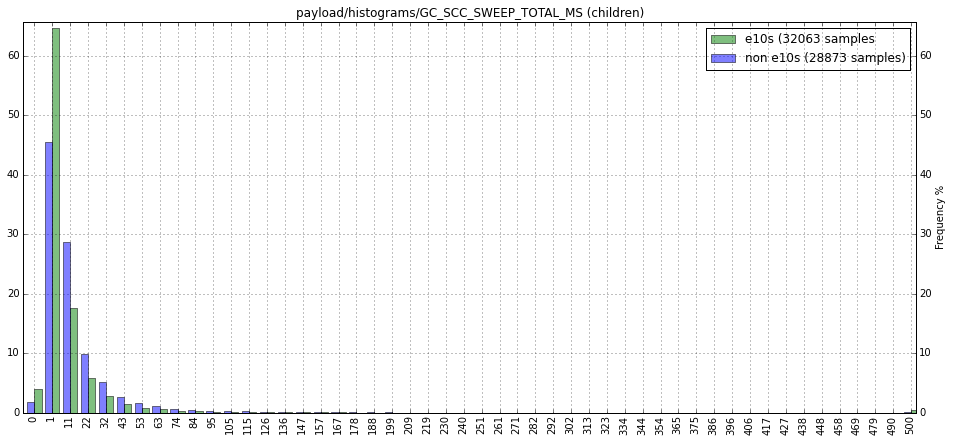

The probability that the distributions for payload/histograms/GC_SCC_SWEEP_TOTAL_MS (children) are differing by chance is 0.00.


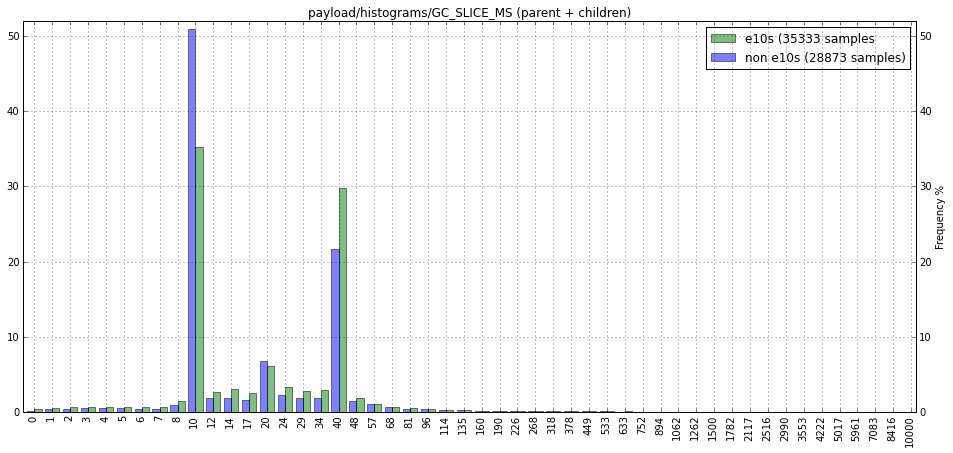

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent + children) are differing by chance is 0.00.


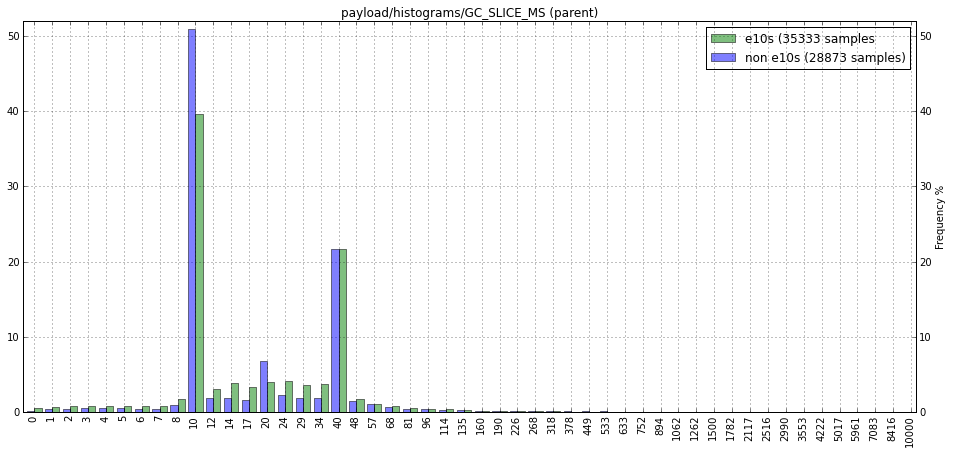

The probability that the distributions for payload/histograms/GC_SLICE_MS (parent) are differing by chance is 0.00.


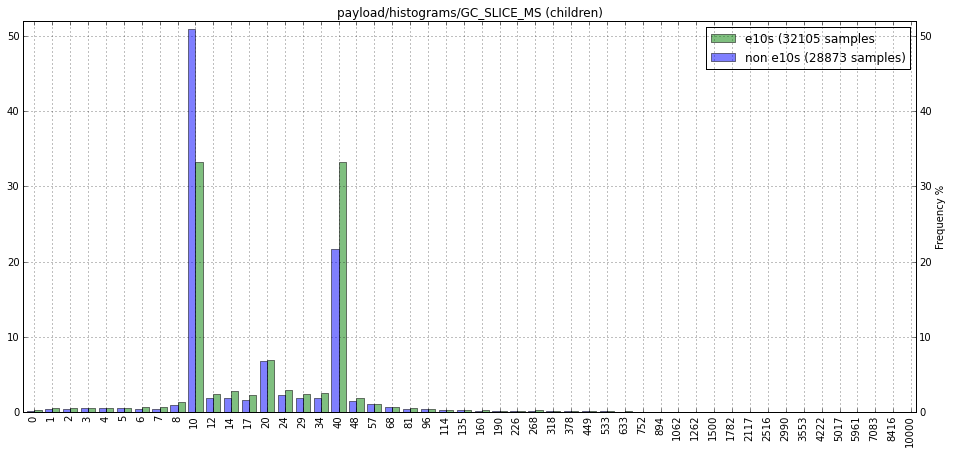

The probability that the distributions for payload/histograms/GC_SLICE_MS (children) are differing by chance is 0.00.


In [35]:
compare_histograms(subset,                     
                   "payload/histograms/GC_MARK_GRAY_MS", 
                   "payload/histograms/GC_SLICE_MS", 
                   "payload/histograms/GC_SCC_SWEEP_TOTAL_MS", 
                   "payload/histograms/GC_SCC_SWEEP_MAX_PAUSE_MS")

#### g) Cycle Collector

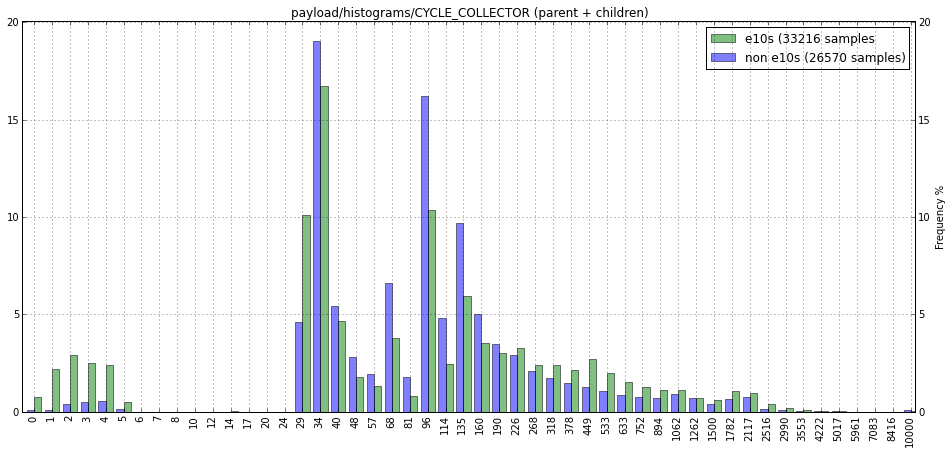

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent + children) are differing by chance is 0.00.


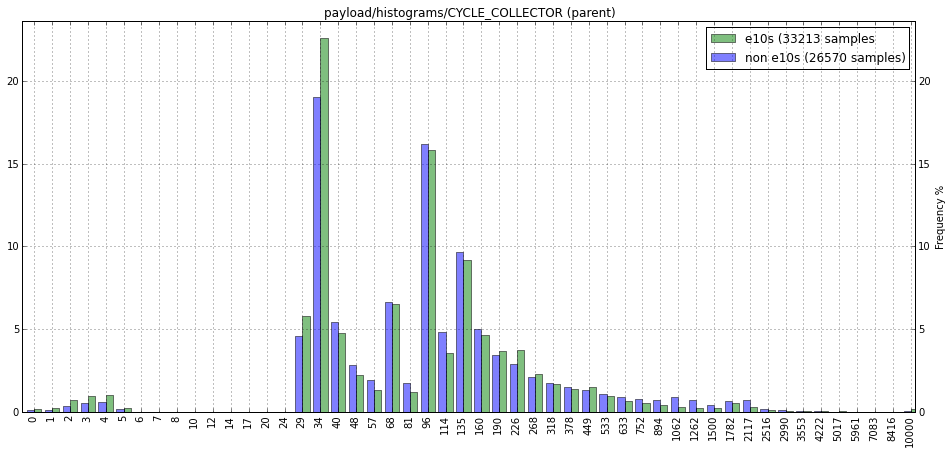

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (parent) are differing by chance is 0.00.


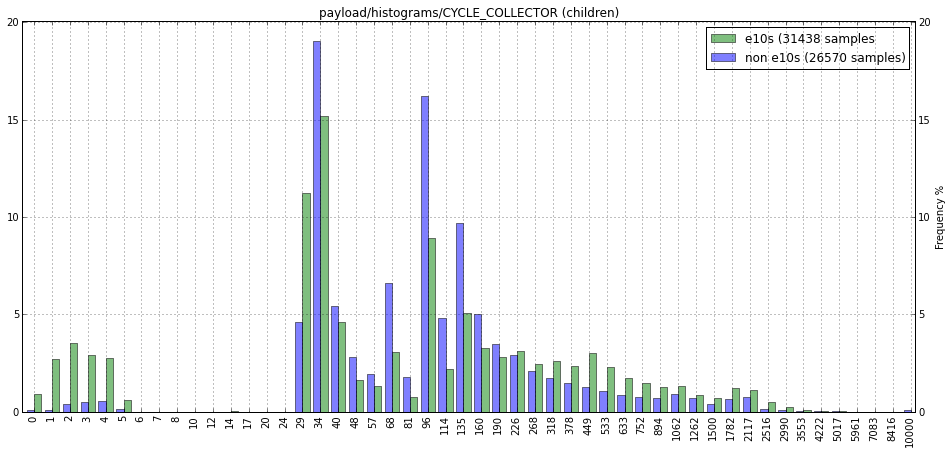

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR (children) are differing by chance is 0.00.


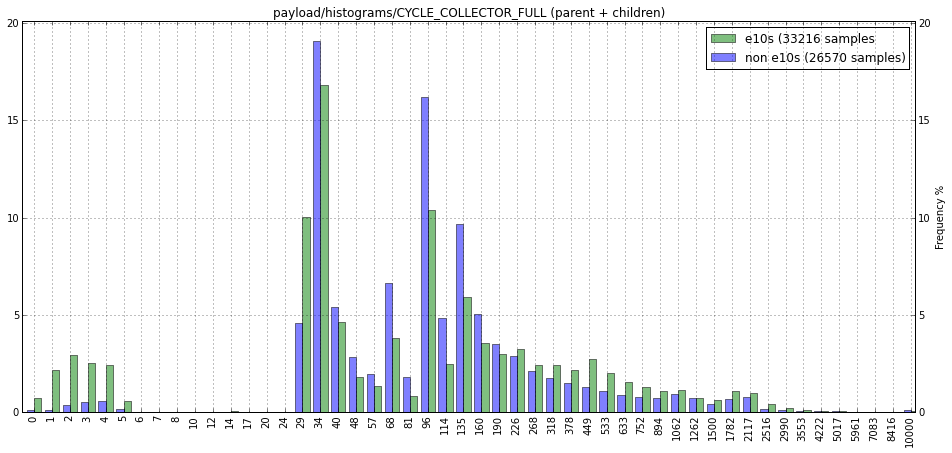

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent + children) are differing by chance is 0.00.


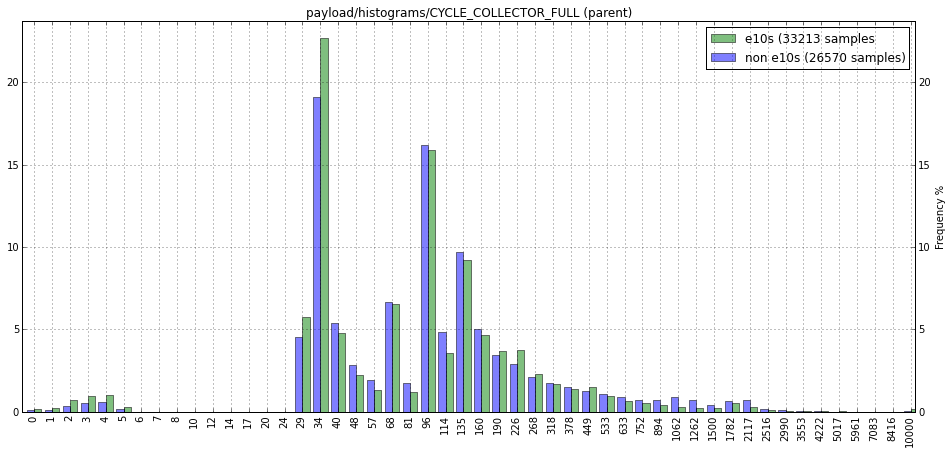

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (parent) are differing by chance is 0.00.


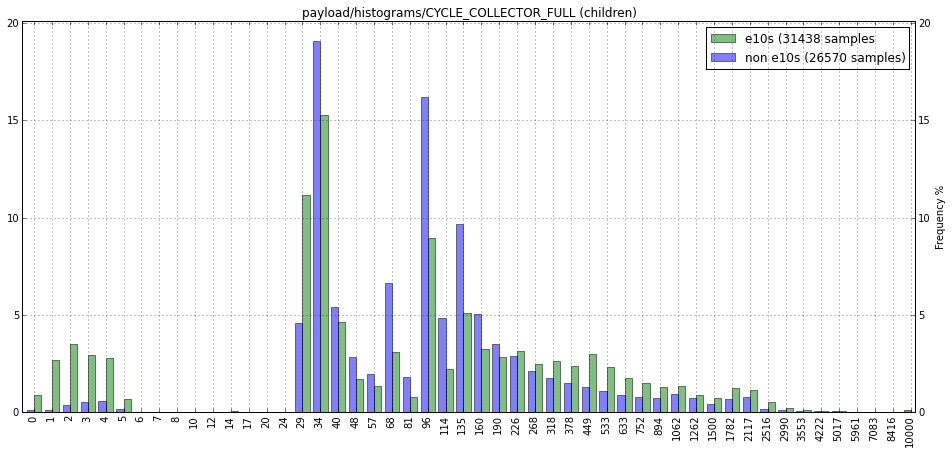

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_FULL (children) are differing by chance is 0.00.


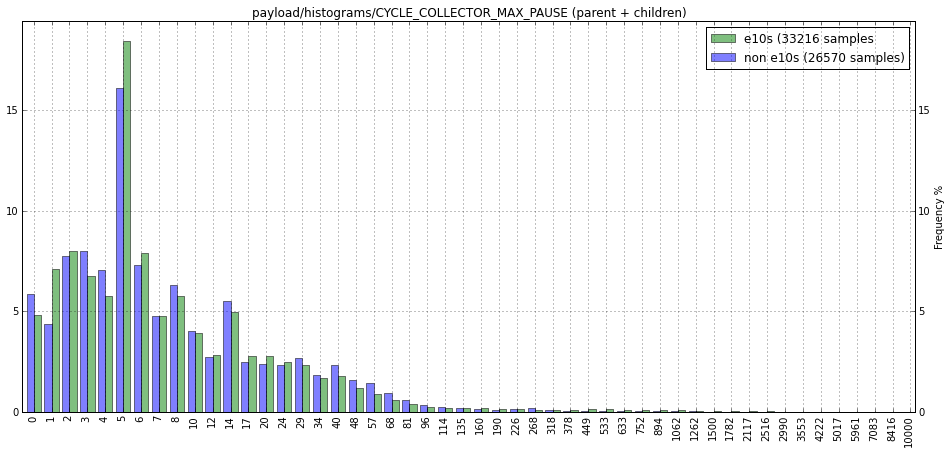

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent + children) are differing by chance is 0.00.


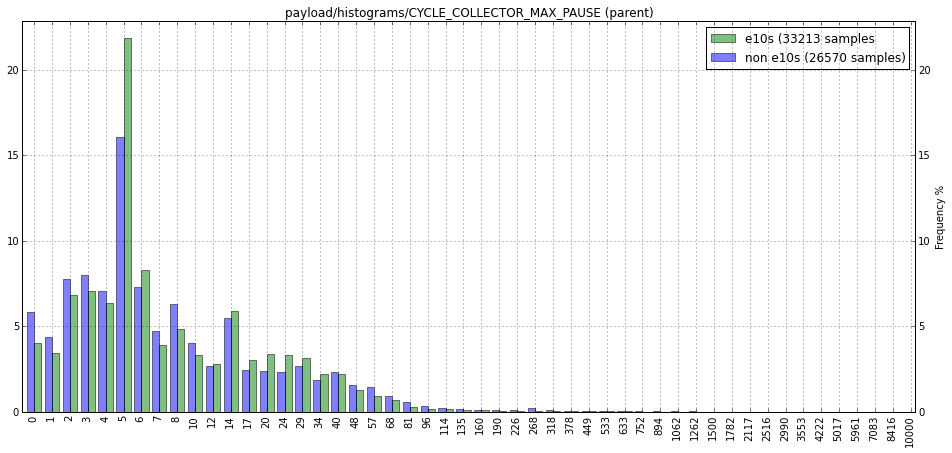

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (parent) are differing by chance is 0.00.


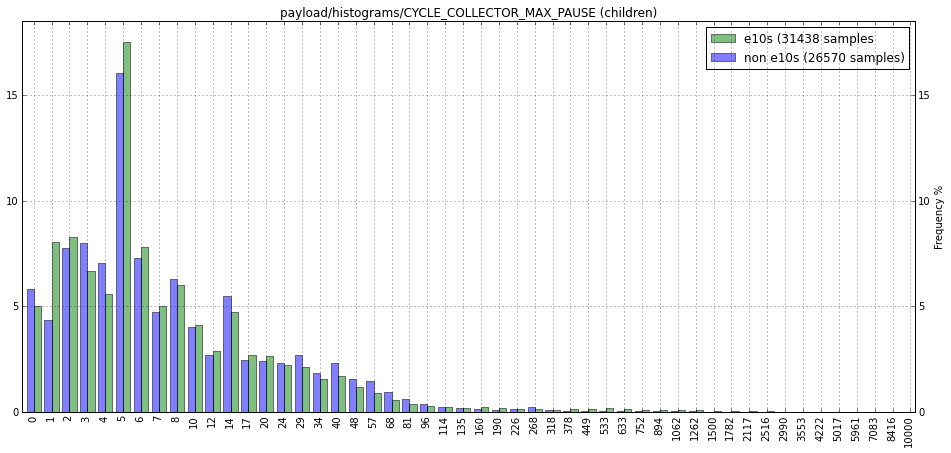

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE (children) are differing by chance is 0.00.


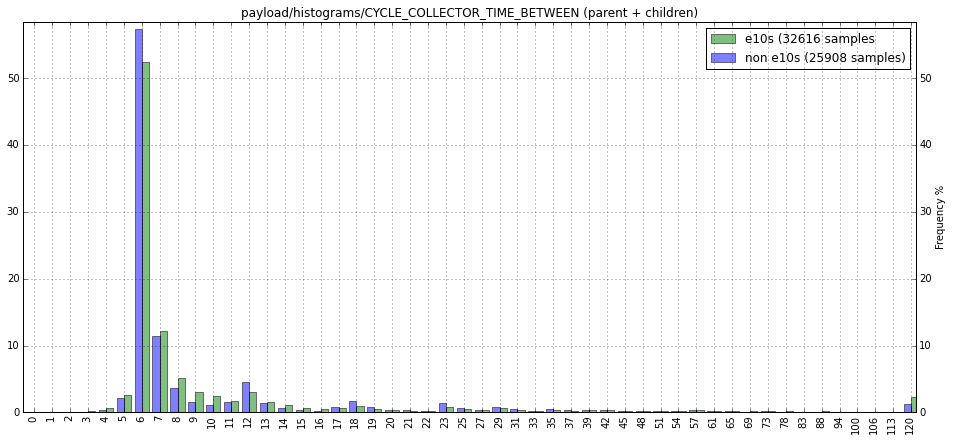

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent + children) are differing by chance is 0.00.


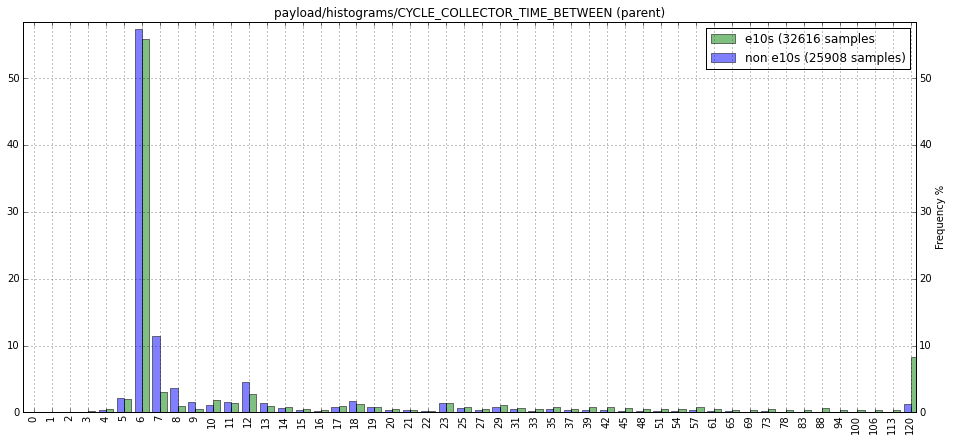

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (parent) are differing by chance is 0.00.


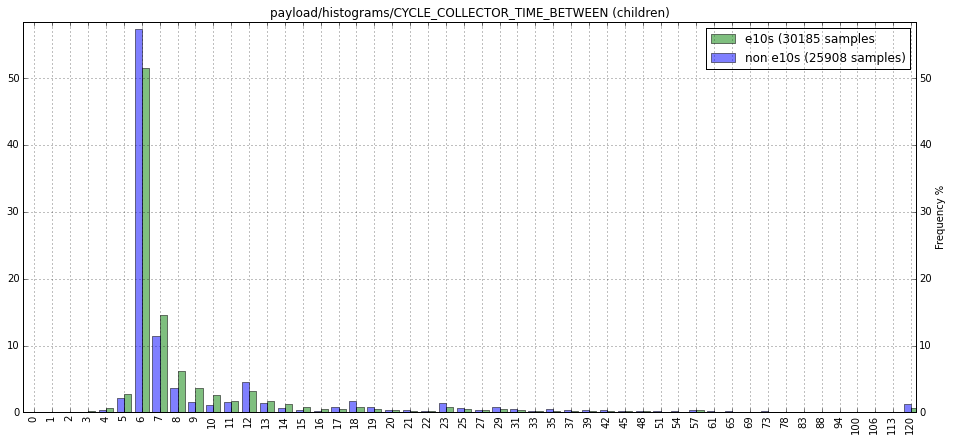

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN (children) are differing by chance is 0.00.


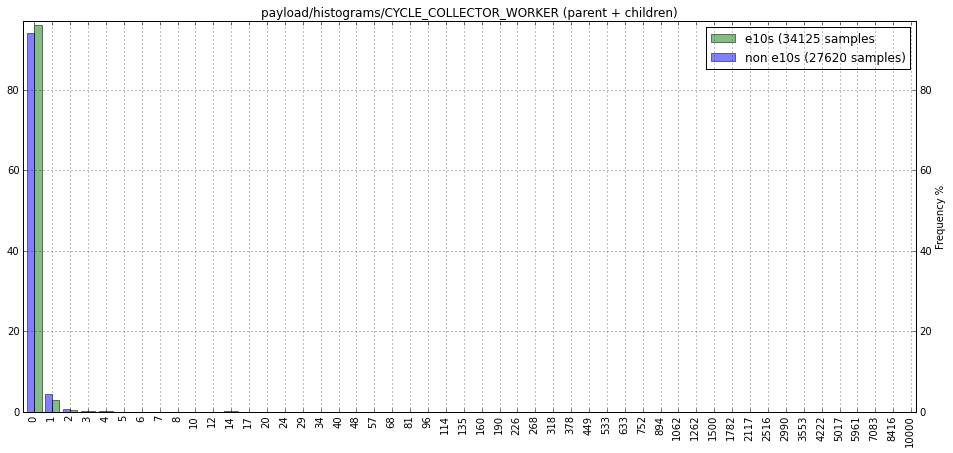

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent + children) are differing by chance is 0.00.


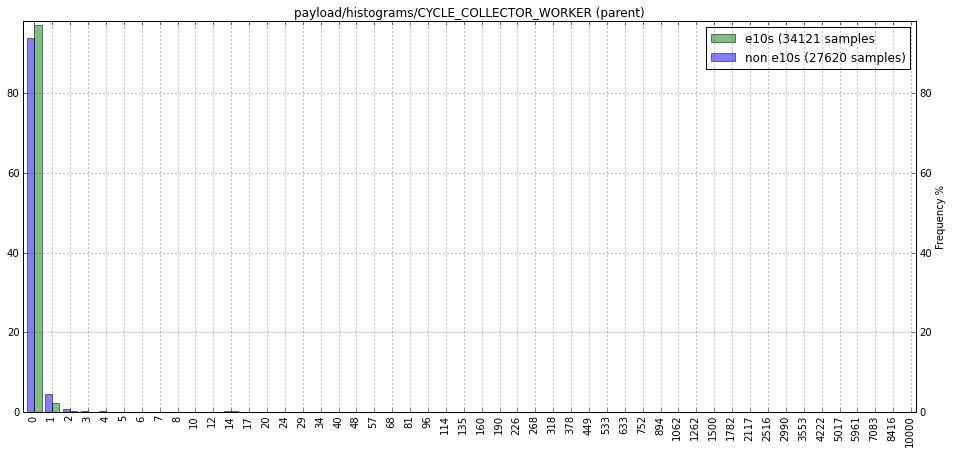

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (parent) are differing by chance is 0.00.


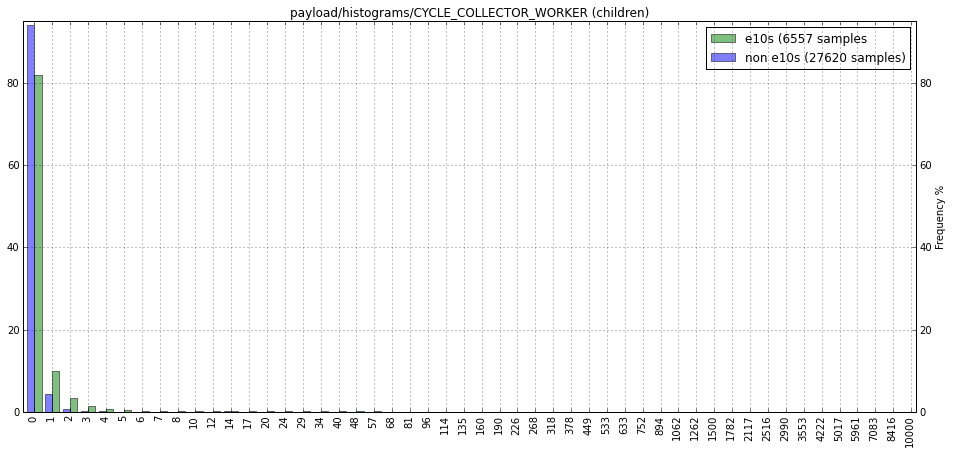

The probability that the distributions for payload/histograms/CYCLE_COLLECTOR_WORKER (children) are differing by chance is 0.00.


In [36]:
compare_histograms(subset,
                   "payload/histograms/CYCLE_COLLECTOR",
                   "payload/histograms/CYCLE_COLLECTOR_WORKER",
                   "payload/histograms/CYCLE_COLLECTOR_FULL",
                   "payload/histograms/CYCLE_COLLECTOR_MAX_PAUSE",
                   "payload/histograms/CYCLE_COLLECTOR_TIME_BETWEEN")